In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn

In [ ]:
# Load data
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url, usecols=[1])
data = df.values.astype('float32')
train_size = int(len(data) * 0.7)
train_data, test_data = data[:train_size], data[train_size:]

# Normalize data
mean, std = train_data.mean(), train_data.std()
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

# Create sequence data
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        X.append(seq)
        y.append(label)
    return np.array(X), np.array(y)

seq_length = 12
train_X, train_y = create_sequences(train_data, seq_length)
test_X, test_y = create_sequences(test_data, seq_length)

# Convert to tensors
train_X = torch.from_numpy(train_X).float()
train_y = torch.from_numpy(train_y).float()
test_X = torch.from_numpy(test_X).float()
test_y = torch.from_numpy(test_y).float()

# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Define training function
def train(model, train_X, train_y, test_X, test_y, num_epochs=300, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(train_X)
        loss = criterion(output, train_y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        with torch.no_grad():
            model.eval()
            test_output = model(test_X)
            test_loss = criterion(test_output, test_y)
            test_losses.append(test_loss.item())
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, train loss: {loss.item():.4f}, test loss: {test_loss.item():.4f}')
    return train_losses, test_losses

# Train model
input_size = 1
hidden_size = 50
output_size = 1
model = LSTM(input_size, hidden_size, output_size)
train_losses, test_losses = train(model, train_X, train_y, test_X, test_y, num_epochs=300)

# Plot training and test losses
#plt.plot(train_losses, label='Train loss')
#plt.plot(test_losses, label='Test loss')
#plt.legend()
#plt.show()


Epoch 0, train loss: 0.8243, test loss: 8.8759
Epoch 10, train loss: 0.6811, test loss: 7.0003
Epoch 20, train loss: 0.4822, test loss: 4.4998
Epoch 30, train loss: 0.2345, test loss: 1.9998
Epoch 40, train loss: 0.2348, test loss: 1.8639
Epoch 50, train loss: 0.2024, test loss: 2.3203
Epoch 60, train loss: 0.1994, test loss: 2.5131
Epoch 70, train loss: 0.1955, test loss: 2.3227
Epoch 80, train loss: 0.1908, test loss: 2.2668
Epoch 90, train loss: 0.1867, test loss: 2.1618
Epoch 100, train loss: 0.1816, test loss: 2.1174
Epoch 110, train loss: 0.1751, test loss: 2.0895
Epoch 120, train loss: 0.1670, test loss: 2.0082
Epoch 130, train loss: 0.1561, test loss: 1.9145
Epoch 140, train loss: 0.1394, test loss: 1.7862
Epoch 150, train loss: 0.1121, test loss: 1.7827
Epoch 160, train loss: 0.0793, test loss: 1.9942
Epoch 170, train loss: 0.0641, test loss: 1.1519
Epoch 180, train loss: 0.0551, test loss: 0.7753
Epoch 190, train loss: 0.0507, test loss: 0.5653
Epoch 200, train loss: 0.0468, 

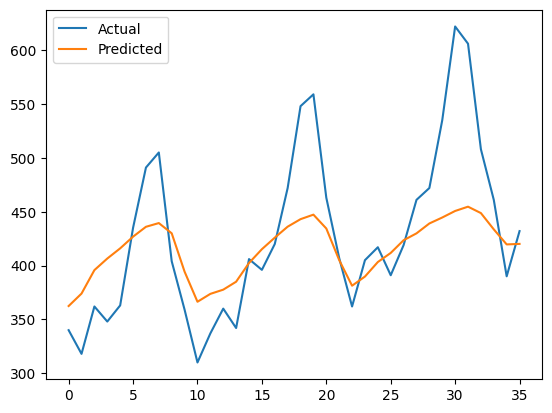

In [ ]:
# Make predictions
model.eval()
train_predict = model(train_X).detach().numpy()
test_predict = model(test_X).detach().numpy()

# Invert predictions to original scale
train_predict = train_predict * std + mean
train_y = train_y * std + mean
test_predict = test_predict * std + mean
test_y = test_y * std + mean

# Calculate MSE
from sklearn.metrics import mean_squared_error
train_mse = mean_squared_error(train_y, train_predict)
test_mse = mean_squared_error(test_y, test_predict)
#print(f'Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')

# Plot actual vs predicted values
#plt.plot(train_y, label='Actual')
#plt.plot(train_predict, label='Predicted')
#plt.legend()
#plt.show()

plt.plot(test_y, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.legend()
plt.show()
